In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Training on {}'.format(device))

Training on cuda


In [3]:
train_folder = 'data/train/'
test_folder = 'data/test/'

classes = {'butterfly' : 0,
           "cat" : 1,
           'chicken' : 2,
           'cow' : 3,
           'dog' : 4,
           'elephant' : 5,
           'horse' : 6,
           'sheep' : 7,
           'spider' : 8,
           'squirrel' : 9
}

reverse_classes = {value: key for key, value in classes.items()}

In [4]:
print('Number of files in the train folder', len(os.listdir(train_folder)))
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 21054
Number of files in the test folder 4950


In [5]:
# for image in os.listdir(test_folder):
#     img = np.asarray(Image.open(test_folder+image))
#     img_chanal = img.shape[-1]
#     if img_chanal in [1, 4, 640] or img_chanal == 4:
#         os.remove(test_folder + image)

In [6]:
# a = set()
# for image in os.listdir(test_folder):
#     img = np.asarray(Image.open(test_folder+image))
#     img_chanal = img.shape[-1]
#     a.add(img_chanal)

In [7]:
class AnimalsDataset(Dataset):
    """Animals dataset."""
    
    def __init__(self, folder, transform=None):
        self.root_dir = folder
        self.data = os.listdir(folder)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_id = self.data[index]
        img = Image.open(os.path.join(self.root_dir, img_id))
        y = classes[img_id.split('_')[0]]
        
        if self.transform:
            img = self.transform(img)
            
        return img, y

In [8]:
train_dataset = AnimalsDataset(train_folder, transform=transforms.Compose([
                                                transforms.Resize((224, 224)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.5218, 0.5039, 0.4166],
                                                                     std=[0.2661, 0.2614, 0.2787])
                                            ]))
test_dataset = AnimalsDataset(test_folder, transform=transforms.Compose([
                                                transforms.Resize((224, 224)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.5218, 0.5039, 0.4166],
                                                                 std=[0.2661, 0.2614, 0.2787])
                                            ]))

In [73]:
# imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)

In [74]:
# imgs.view(3, -1).mean(dim=1)

In [75]:
# imgs.view(3, -1).std(dim=1)

In [76]:
def visualize_samples(dataset, indices, count=10):
    plt.figure(figsize=(count*3, 3))
    displat_indices = indices[:count]
    
    for i, index in enumerate(displat_indices):
        x, y = dataset[index]
        plt.subplot(1, count, i+1)
        plt.title('Label: %s' % y)
        plt.imshow(x.permute(1, 2, 0))
        plt.grid(False)
        plt.axis('off')
        
    plt.show()

In [77]:
indices = np.random.choice(np.arange(len(train_dataset)), 17, replace=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

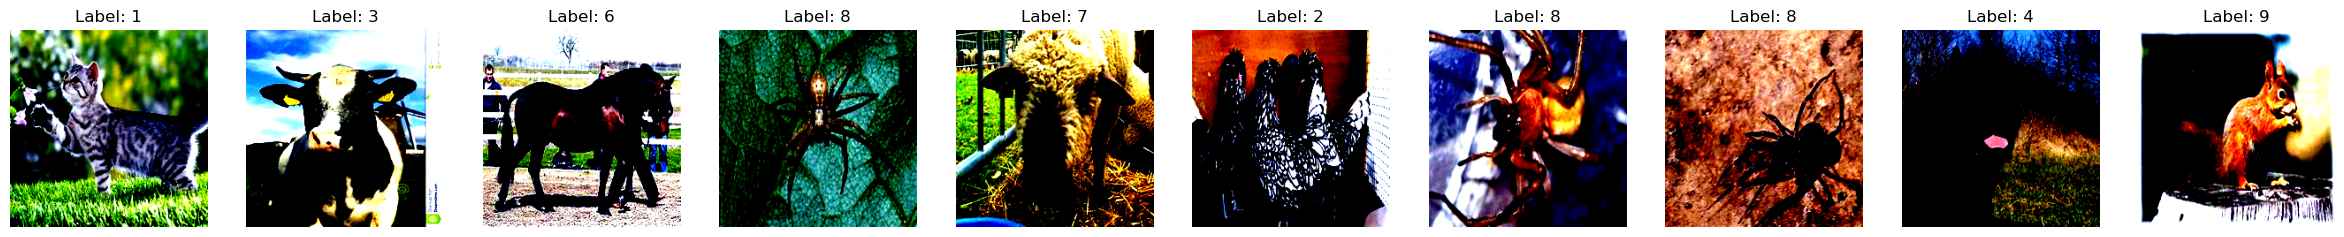

In [78]:
visualize_samples(train_dataset, indices)

In [9]:
batch_size = 64
data_size = len(train_dataset)
validation_fraction = 0.2

val_split = int(np.floor(validation_fraction * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[val_split:], indices[:val_split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
def training_loop(num_epochs, model, train_loader, val_loader, loss_fn, optimizer):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (img, labels) in enumerate(train_loader): 
            img = img.to(device)
            labels = labels.to(device)
             
            prediction = model(img)
            loss = loss_fn(prediction, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_accum += loss.item()
            total_samples += labels.shape[0]
            
            _, out = torch.max(prediction, 1)
            correct_samples += torch.sum(out == labels).item()
        
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(ave_loss)
        train_history.append(train_accuracy)  
        val_history.append(val_accuracy)
        
        print('[{} | {}] Loss: {} | Train accuracy: {:3f} | Validation Accuracy: {:3f} | Time {}'.format(epoch+1, num_epochs, ave_loss, train_accuracy, val_accuracy, time.time()-start_time))
        
    return loss_history, train_history, val_history  

def compute_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img, labels in val_loader:
            img = img.to(device=device)
            labels = labels.to(device=device)
            out = model(img)
            _, prediction = torch.max(out, 1)
            correct += torch.sum(prediction == labels).item()
            total += labels.shape[0]
            
    return correct / total


In [17]:
model_res_net = resnet50(weights=ResNet50_Weights.DEFAULT)
for param in model_res_net.parameters():
    param.requires_grad = False

num_ftrs = model_res_net.fc.in_features
model_res_net.fc = nn.Linear(num_ftrs, 10) 
model_res_net = model_res_net.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_res_net.fc.parameters(), lr=1e-3)   

In [19]:
loss_history, train_history, val_history = training_loop(5, model_res_net, train_loader, val_loader, criterion, optimizer)

[1 | 5] Loss: 0.4273894089539695 | Train accuracy: 0.918665 | Validation Accuracy: 0.973634 | Time 1733.985229253769
[2 | 5] Loss: 0.12404622572399818 | Train accuracy: 0.972631 | Validation Accuracy: 0.978147 | Time 1660.3383812904358
[3 | 5] Loss: 0.09127565865677573 | Train accuracy: 0.978034 | Validation Accuracy: 0.977197 | Time 1667.8158297538757
[4 | 5] Loss: 0.07359318088513477 | Train accuracy: 0.982783 | Validation Accuracy: 0.977910 | Time 1590.342435836792
[5 | 5] Loss: 0.06177593257894364 | Train accuracy: 0.985217 | Validation Accuracy: 0.977435 | Time 1552.5132377147675


In [20]:
torch.save(model_res_net.state_dict(), 'model_weights.pth')

In [ ]:
print(compute_accuracy(model, test_loader))

In [105]:
print(f"Accuracy on test: {compute_accuracy(model_res_net, test_loader)}")

Accuracy on test: 0.9703030303030303


In [21]:
def visualize_model(model, loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    reverse_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.5218/0.2661, -0.5039/0.2614, -0.4166/0.2787], std=[1/0.2661, 1/0.2614, 1/0.2787]),
    ])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {reverse_classes[preds[j].item()]}')

                original_image = reverse_normalize(inputs.cpu().data[j])
                plt.imshow(original_image.permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return
        model.train(mode=was_training)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


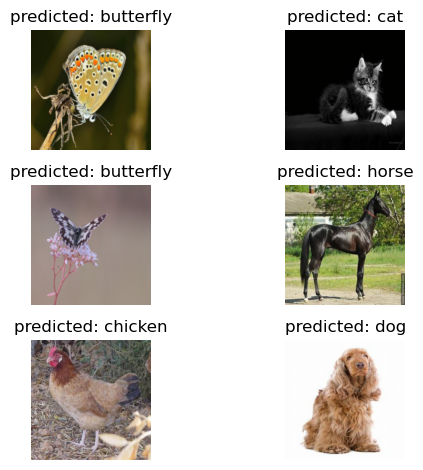

In [22]:
visualize_model(model_res_net, test_loader)